In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import os

# Set our plot style
sns.set(style="whitegrid")
print("--- Notebook Started: Generating data in memory ---")

# --- 1. SIMULATE DATA (from 1_simulate_data.py) ---
print("Generating simulated data in memory...")
timestamps = pd.date_range(start='2024-01-01', end='2024-12-31 23:59:59', freq='h')
n = len(timestamps)

# Simulate Air Quality Index (AQI)
base_aqi = 40
aqi_weekly_cycle = 15 * (1 + np.sin(2 * np.pi * timestamps.dayofweek / 7))
aqi_noise = np.random.normal(0, 5, n)
aqi = base_aqi + aqi_weekly_cycle + aqi_noise

# Simulate Traffic Load
hour = timestamps.hour
base_traffic = np.random.uniform(10, 20, n)
morning_rush = 70 * np.exp(-((hour - 8.5)**2) / (2 * 1.5**2))
evening_rush = 60 * np.exp(-((hour - 17.5)**2) / (2 * 2**2))
traffic_load = base_traffic + morning_rush + evening_rush + np.random.normal(0, 3, n)

# Simulate Energy Consumption
base_energy = 500
daytime_business_use = 150 * (1 + np.sin(2 * np.pi * (hour - 8) / 24))
evening_residential_peak = 100 * np.exp(-((hour - 19)**2) / (2 * 2**2))
energy_consumption = base_energy + daytime_business_use + evening_residential_peak + np.random.normal(0, 15, n)

# Combine into a DataFrame
df = pd.DataFrame({
    'timestamp': timestamps,
    'aqi': aqi,
    'traffic_load': traffic_load,
    'energy_consumption': energy_consumption
})

# Clean up
df['aqi'] = df['aqi'].clip(lower=0)
df['traffic_load'] = df['traffic_load'].clip(lower=0)
df['energy_consumption'] = df['energy_consumption'].clip(lower=0)
df = df.round(2)
print("Data generated successfully.")

# --- 2. PROCESS DATA ---
print("Processing data...")
# Set the timestamp as the index for time-series analysis
df.set_index('timestamp', inplace=True)

print(f"✅ Success! DataFrame is ready in memory with {len(df)} rows.")
print("\n--- Data Head ---")
df.head()

--- Notebook Started: Generating data in memory ---
Generating simulated data in memory...
Data generated successfully.
Processing data...
✅ Success! DataFrame is ready in memory with 8784 rows.

--- Data Head ---


,aqi,traffic_load,energy_consumption
timestamp,,,
2024-01-01 00:00:00,62.45,7.88,523.21
2024-01-01 01:00:00,54.56,20.04,497.05
2024-01-01 02:00:00,50.66,24.80,512.67
2024-01-01 03:00:00,50.77,12.84,506.51
2024-01-01 04:00:00,48.51,13.88,528.25


Plotting the first week of data...


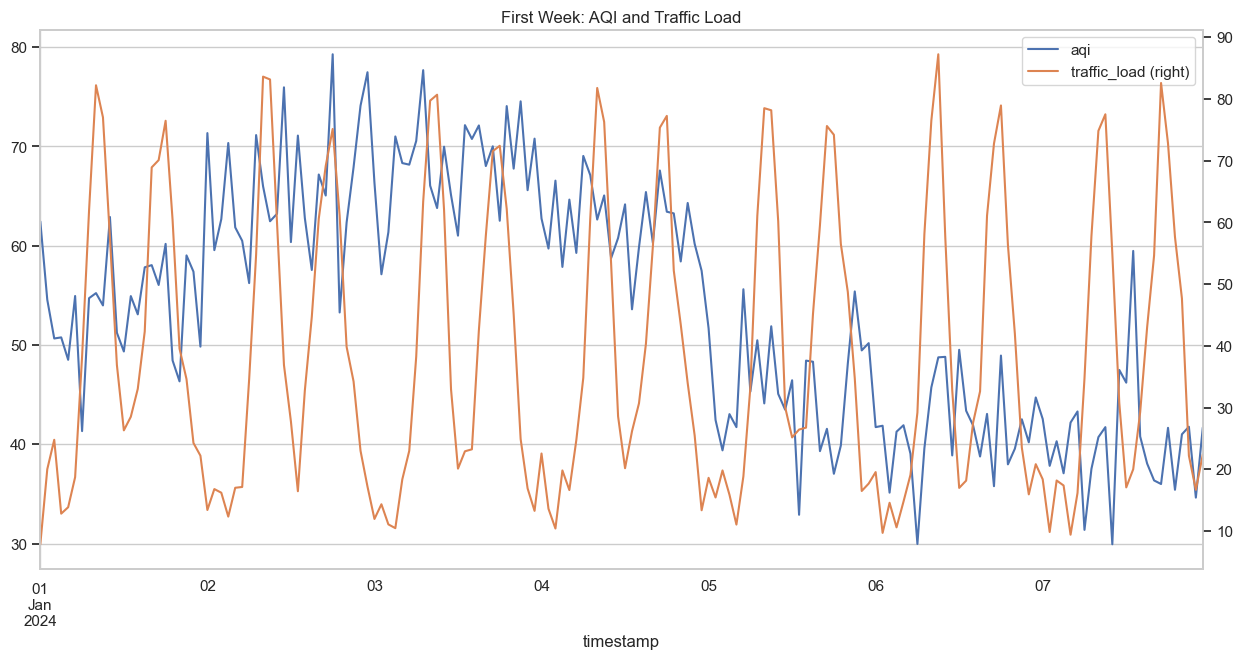

In [3]:
# --- 3. VISUALIZE DATA ---
print("Plotting the first week of data...")

# Plot the first 7 days (168 hours)
df.head(168).plot(
    y=['aqi', 'traffic_load'],
    figsize=(15, 7),
    title='First Week: AQI and Traffic Load',
    secondary_y=['traffic_load'] # Plot traffic on a separate y-axis
)

plt.show()

Calculating correlation matrix...


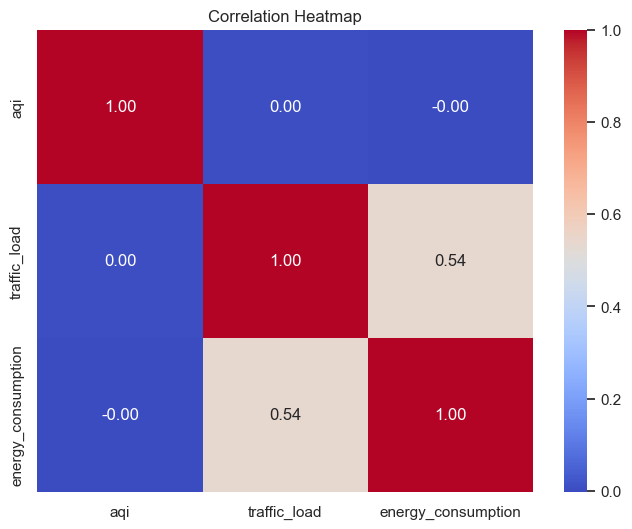

In [4]:
# --- 4. ANALYZE: Correlation Heatmap ---
print("Calculating correlation matrix...")

# Calculate the correlation between all columns
corr_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

Plotting data distributions...


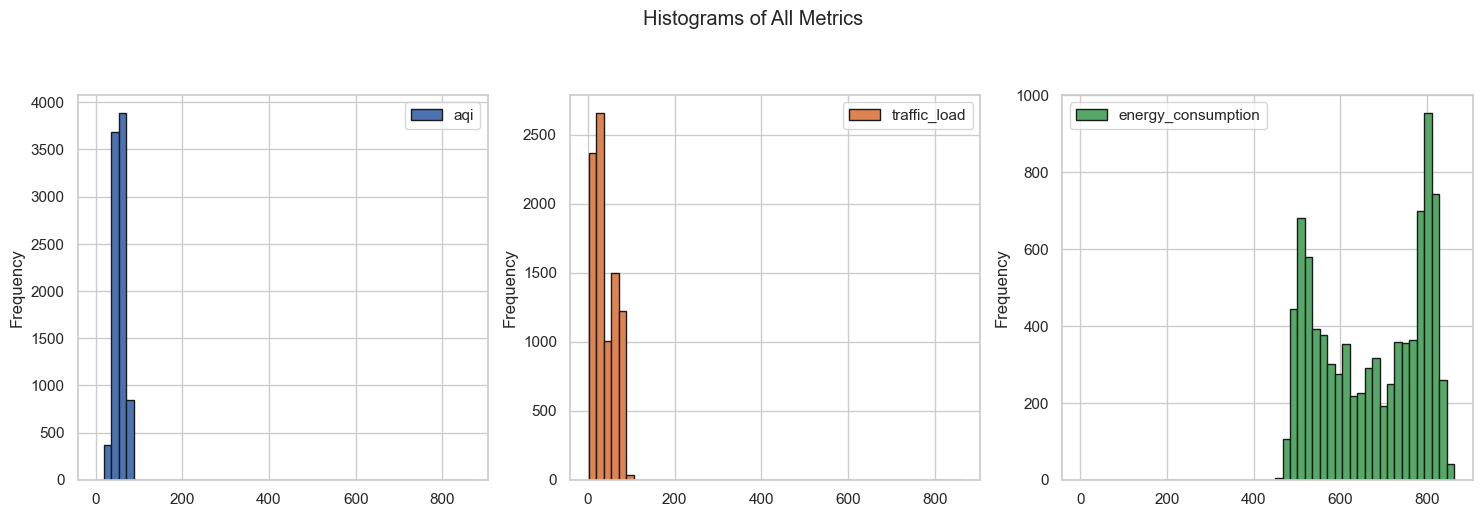

In [5]:
# --- 5. ANALYZE: Data Distributions ---
print("Plotting data distributions...")

# Plot a histogram for each column
df.plot(
    kind='hist',
    subplots=True,   # Give each column its own plot
    layout=(1, 3),   # Arrange plots in 1 row, 3 columns
    figsize=(18, 5),
    bins=50,         # Use 50 bars for detail
    edgecolor='k'    # Add a black edge to the bars
)

plt.suptitle('Histograms of All Metrics', y=1.05)
plt.show()

--- Step 4: Machine Learning (Linear Regression) ---
Created time features: 'hour' and 'dayofweek'
Features (X): ['traffic_load', 'energy_consumption', 'hour', 'dayofweek']
Target (y): aqi
Training set size: 7027 rows
Testing set size: 1757 rows

Training Linear Regression model...
Model trained successfully.

--- Model Evaluation ---
R-squared (R²): 0.432
Root Mean Squared Error (RMSE): 8.838 AQI points

Plotting predictions vs. actual values...


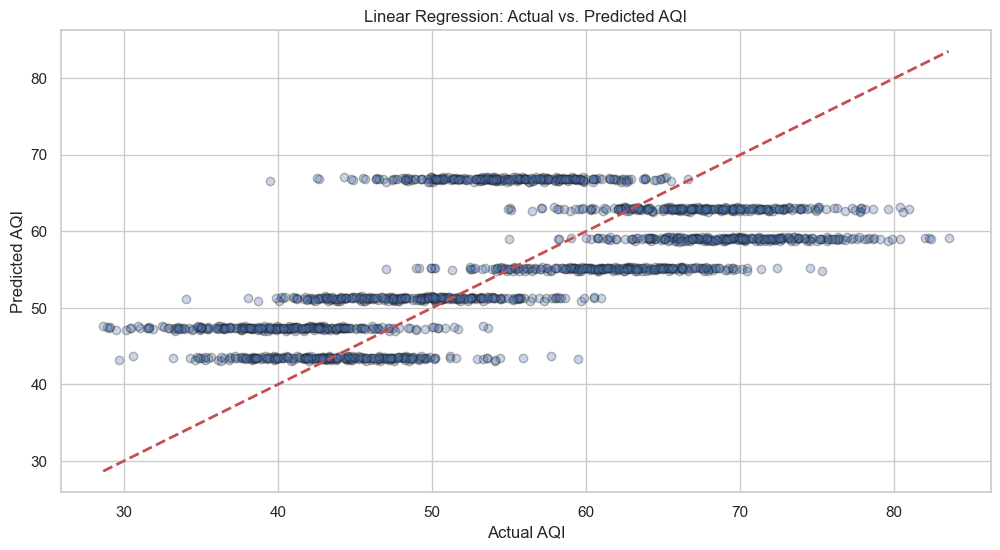

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

print("--- Step 4: Machine Learning (Linear Regression) ---")

# --- 1. Feature Engineering ---
# Our models can't understand 'timestamp'. We need to
# convert it into numbers they can use.
df_ml = df.copy() # Make a copy to be safe

# Create new columns for time features
df_ml['hour'] = df_ml.index.hour
df_ml['dayofweek'] = df_ml.index.dayofweek
# (0=Monday, 6=Sunday)

print("Created time features: 'hour' and 'dayofweek'")

# --- 2. Define Features (X) and Target (y) ---
# X = The "causes" (our features)
features = ['traffic_load', 'energy_consumption', 'hour', 'dayofweek']
X = df_ml[features]

# y = The "effect" we want to predict (our target)
y = df_ml['aqi']

print(f"Features (X): {features}")
print(f"Target (y): aqi")

# --- 3. Split Data into Training and Testing Sets ---
# We'll train the model on 80% of the data and test it
# on the 20% it has never seen before.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]} rows")
print(f"Testing set size: {X_test.shape[0]} rows")

# --- 4. Create and Train the Model ---
print("\nTraining Linear Regression model...")
model = LinearRegression()
model.fit(X_train, y_train)
print("Model trained successfully.")

# --- 5. Evaluate the Model ---
print("\n--- Model Evaluation ---")
# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate R-squared: "How much of the change in AQI
# can our model explain?" (Higher is better, 1.0 is perfect)
r2 = r2_score(y_test, y_pred)
print(f'R-squared (R²): {r2:.3f}')

# Calculate RMSE: "On average, how many AQI points
# was our model's prediction off by?" (Lower is better)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error (RMSE): {rmse:.3f} AQI points')

# --- 6. Plot Predictions vs. Actuals ---
print("\nPlotting predictions vs. actual values...")
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred, alpha=0.3, edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual AQI')
plt.ylabel('Predicted AQI')
plt.title('Linear Regression: Actual vs. Predicted AQI')
plt.show()

--- Step 4b: Machine Learning (Random Forest) ---
Training Random Forest model...
Model trained successfully.

--- Model Evaluation (Random Forest) ---
R-squared (R²): 0.789
Root Mean Squared Error (RMSE): 5.384 AQI points

Plotting predictions vs. actual values...


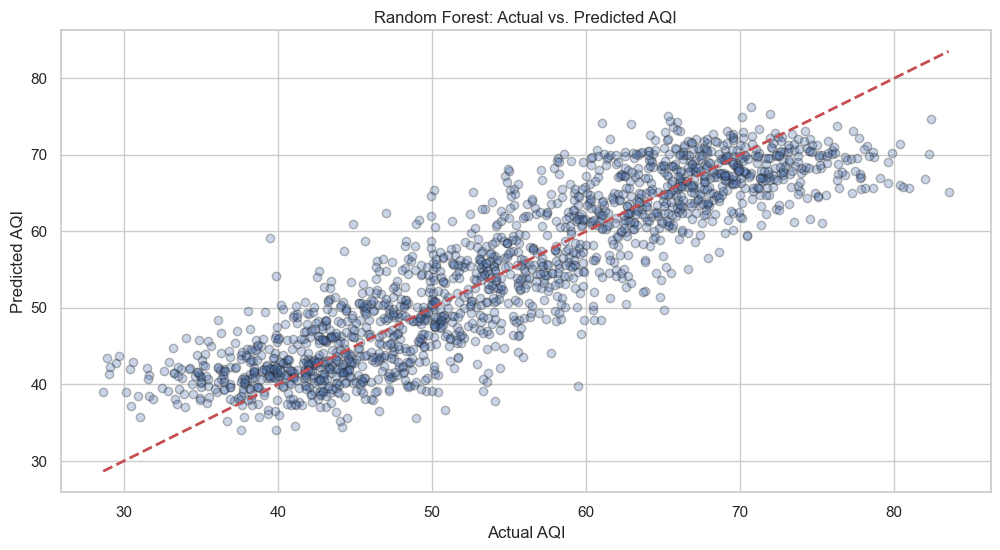

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

print("--- Step 4b: Machine Learning (Random Forest) ---")

# We already have our X_train, X_test, y_train, y_test
# from the previous cell, so we can reuse them.

# --- 1. Create and Train the Model ---
print("Training Random Forest model...")
# n_estimators=100 means we're building 100 Decision Trees
# n_jobs=-1 uses all your computer's CPU cores to speed it up
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
print("Model trained successfully.")

# --- 2. Evaluate the Model ---
print("\n--- Model Evaluation (Random Forest) ---")
y_pred_rf = rf_model.predict(X_test)

# Calculate R-squared
r2_rf = r2_score(y_test, y_pred_rf)
print(f'R-squared (R²): {r2_rf:.3f}')

# Calculate RMSE
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print(f'Root Mean Squared Error (RMSE): {rmse_rf:.3f} AQI points')

# --- 3. Plot Predictions vs. Actuals ---
print("\nPlotting predictions vs. actual values...")
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.3, edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual AQI')
plt.ylabel('Predicted AQI')
plt.title('Random Forest: Actual vs. Predicted AQI')
plt.show()

--- Step 5: Deep Learning (LSTM Time-Series Forecasting) ---
Data shape (Total rows, Features): (8784, 5)
Sequence shape (Samples, Look-back, Features): (8760, 24, 5)
Target shape (Samples,): (8760,)

Training sequences: 7884
Testing sequences: 876

Building LSTM model...


C:\Users\miriy\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50)                  │          11,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,251 (43.95 KB)

 Trainable params: 11,251 (43.95 KB)

 Non-trainable params: 0 (0.00 B)


Training LSTM model (this may take a few minutes)...
Epoch 1/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0233 - val_loss: 0.0094
Epoch 2/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0079 - val_loss: 0.0089
Epoch 3/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0073 - val_loss: 0.0088
Epoch 4/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0069 - val_loss: 0.0083
Epoch 5/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0068 - val_loss: 0.0084
Epoch 6/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0067 - val_loss: 0.0079
Epoch 7/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0067 - val_loss: 0.0076
Epoch 8/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0066 - val_loss: 0.0081
Epoch 9/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0066 - val_loss: 0.0080
Epoch 10/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0066 - val_loss: 0.0079
Model trained.

--- Model Evaluation (LSTM) ---
28/28 ━━━━━━━━━━━━━━━━━━━━ 

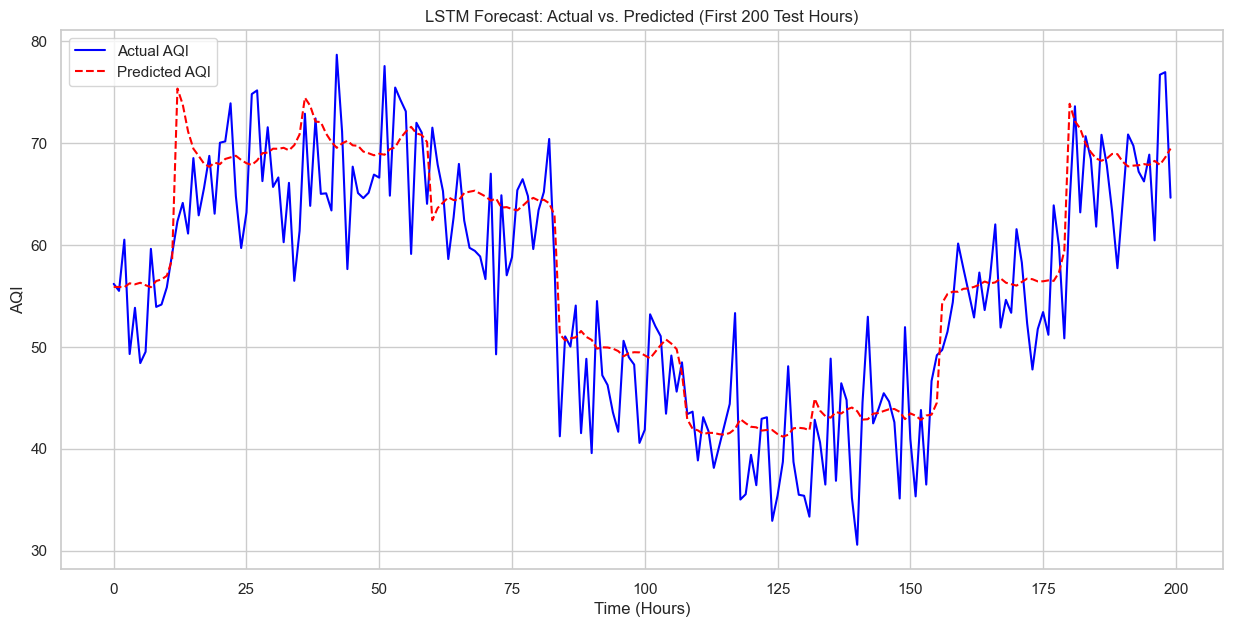

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import numpy as np

print("--- Step 5: Deep Learning (LSTM Time-Series Forecasting) ---")

# --- 1. Prepare Data for Time-Series ---
# We will use ALL our data, not just the 'aqi' column.
# An LSTM can find patterns in how 'traffic' *leads* to 'aqi' changes.
features_df = df_ml.copy() # This is the df with 'hour' and 'dayofweek'

# --- 2. Scale the Data ---
# LSTMs are sensitive to scale. We'll scale all features to be between 0 and 1.
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(features_df)

# We also need a scaler just for our 'aqi' column (which is the first one)
# so we can "un-scale" the predictions later.
scaler_aqi = MinMaxScaler()
scaler_aqi.fit(features_df[['aqi']]) # Note the double brackets

# --- 3. Create Sequences ---
# We need to convert our data into "look-back" sequences.
# look_back = 24 hours (we use the past 24 hours...)
# ...to predict the 1st column (aqi) 1 hour in the future.

def create_sequences(data, look_back=24):
    X, y = [], []
    for i in range(look_back, len(data)):
        # X is a sequence of the past 24 hours (all features)
        X.append(data[i-look_back:i, :])
        # y is the 'aqi' (column 0) 1 hour in the future
        y.append(data[i, 0])
    return np.array(X), np.array(y)

LOOK_BACK = 24
X_seq, y_seq = create_sequences(scaled_data, LOOK_BACK)

print(f"Data shape (Total rows, Features): {scaled_data.shape}")
print(f"Sequence shape (Samples, Look-back, Features): {X_seq.shape}")
print(f"Target shape (Samples,): {y_seq.shape}")

# --- 4. Split into Train/Test ---
# For time-series, we MUST NOT shuffle.
# We train on the past and test on the (unseen) future.
# We'll use the last 10% of data for our test.
split_index = int(len(X_seq) * 0.9)
X_train_seq, X_test_seq = X_seq[:split_index], X_seq[split_index:]
y_train_seq, y_test_seq = y_seq[:split_index], y_seq[split_index:]

print(f"\nTraining sequences: {X_train_seq.shape[0]}")
print(f"Testing sequences: {X_test_seq.shape[0]}")

# --- 5. Build the LSTM Model ---
print("\nBuilding LSTM model...")
model_lstm = Sequential()
# Input shape = (look_back_steps, num_features)
model_lstm.add(LSTM(
    units=50, 
    activation='relu', 
    input_shape=(X_seq.shape[1], X_seq.shape[2])
))
model_lstm.add(Dense(units=1)) # Output layer: 1 neuron to predict the 1 'aqi' value
model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.summary()

# --- 6. Train the Model ---
print("\nTraining LSTM model (this may take a few minutes)...")
history = model_lstm.fit(
    X_train_seq, y_train_seq,
    epochs=10, 
    batch_size=32,
    validation_data=(X_test_seq, y_test_seq),
    shuffle=False # Very important for time-series
)
print("Model trained.")

# --- 7. Evaluate the Model ---
print("\n--- Model Evaluation (LSTM) ---")
# Make predictions (they will be scaled)
y_pred_scaled = model_lstm.predict(X_test_seq)

# "Un-scale" the predictions and the actual values
y_pred_lstm = scaler_aqi.inverse_transform(y_pred_scaled)
y_test_lstm = scaler_aqi.inverse_transform(y_test_seq.reshape(-1, 1))

# Calculate RMSE
rmse_lstm = np.sqrt(mean_squared_error(y_test_lstm, y_pred_lstm))
print(f'Root Mean Squared Error (RMSE): {rmse_lstm:.3f} AQI points')

# --- 8. Plot Forecast vs. Actuals ---
print("\nPlotting forecast vs. actual values (first 200 test points)...")
plt.figure(figsize=(15, 7))
plt.plot(y_test_lstm[:200], label='Actual AQI', color='blue')
plt.plot(y_pred_lstm[:200], label='Predicted AQI', color='red', linestyle='--')
plt.title('LSTM Forecast: Actual vs. Predicted (First 200 Test Hours)')
plt.xlabel('Time (Hours)')
plt.ylabel('AQI')
plt.legend()
plt.show()


--- Step 6: Deep Learning (Autoencoder for Anomaly Detection) ---
Original data points: 8784
Normal data points: 7768
Shape of normal data for training: (7768, 5)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │              15 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 57 (228.00 B)

 Trainable params: 57 (228.00 B)

 Non-trainable params: 0 (0.00 B)


Training Autoencoder on NORMAL data only...
Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.9599 - val_loss: 0.9054
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8682 - val_loss: 0.8408
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8292 - val_loss: 0.8232
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8181 - val_loss: 0.8156
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8077 - val_loss: 0.7992
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7897 - val_loss: 0.7856
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7797 - val_loss: 0.7794
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7756 - val_loss: 0.7767
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7735 - val_loss: 0.7749
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7719 - val_loss: 0.7734
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7704 - val_loss: 0.7719
Epoch 1

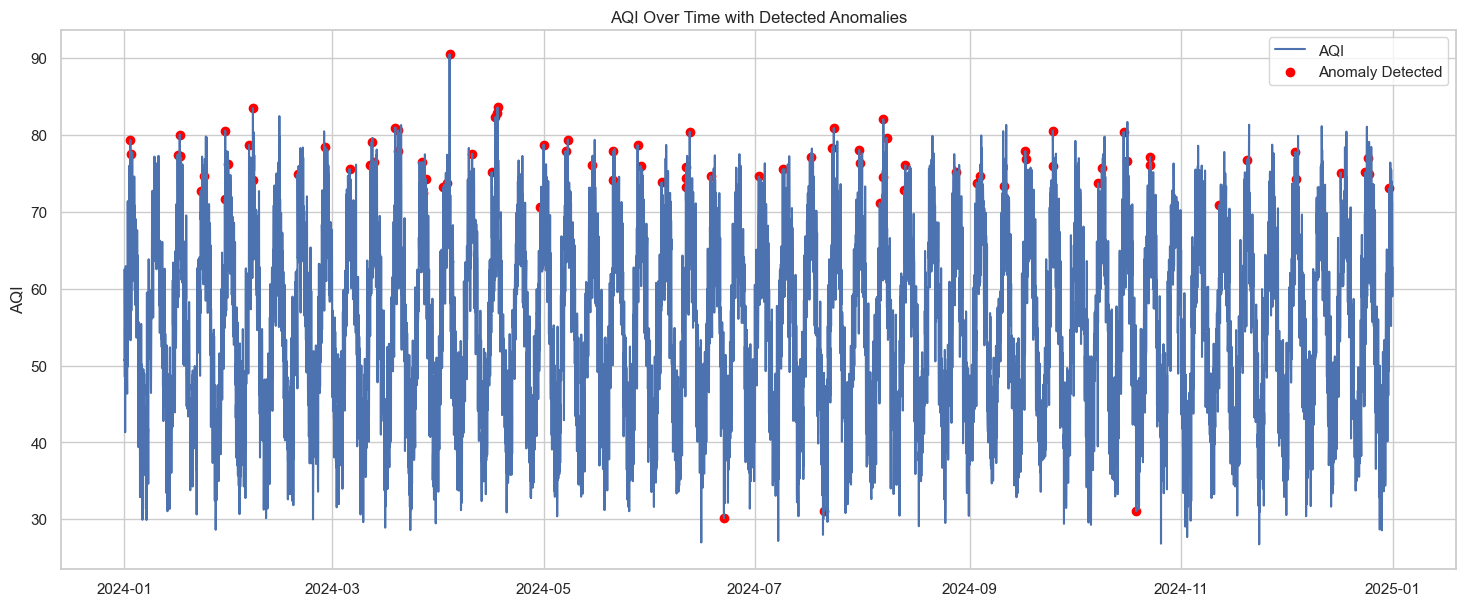

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.preprocessing import StandardScaler

print("--- Step 6: Deep Learning (Autoencoder for Anomaly Detection) ---")

# --- 1. Prepare Data ---
# We'll use the 'scaled_data' from the LSTM step.
# For this task, we'll define "normal" data
# as any time 'aqi' was less than 70.
df_normal = df[df['aqi'] < 70]
print(f"Original data points: {len(df)}")
print(f"Normal data points: {len(df_normal)}")

# We need to re-scale the time features for this new subset
df_normal = df_normal.copy()
df_normal['hour'] = df_normal.index.hour
df_normal['dayofweek'] = df_normal.index.dayofweek

# We'll use a StandardScaler this time
scaler_ae = StandardScaler()
data_normal_scaled = scaler_ae.fit_transform(df_normal)
print(f"Shape of normal data for training: {data_normal_scaled.shape}")

# --- 2. Build the Autoencoder Model ---
input_dim = data_normal_scaled.shape[1] # Should be 5
encoding_dim = 2 # The "bottleneck"

input_layer = Input(shape=(input_dim,))
# Encoder
encoder = Dense(input_dim, activation="relu")(input_layer)
# Bottleneck
encoder = Dense(encoding_dim, activation="relu")(encoder)
# Decoder
decoder = Dense(input_dim, activation="relu")(encoder)
# Autoencoder
autoencoder = Model(inputs=input_layer, outputs=decoder)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()

# --- 3. Train the Autoencoder ---
print("\nTraining Autoencoder on NORMAL data only...")
autoencoder.fit(
    data_normal_scaled, data_normal_scaled, # It learns to predict itself
    epochs=20,
    batch_size=32,
    shuffle=True,
    validation_split=0.1
)
print("Autoencoder trained.")

# --- 4. Find Anomalies ---
print("\nCalculating reconstruction error for ALL data...")
# Scale ALL our data (df_ml) using the same scaler
all_data_scaled = scaler_ae.transform(df_ml)

# Get the model's predictions (reconstructions)
reconstructions = autoencoder.predict(all_data_scaled)

# Calculate the error for every single data point
mse = np.mean(np.power(all_data_scaled - reconstructions, 2), axis=1)
# Add this error score back to our main DataFrame
df_ml['reconstruction_error'] = mse

# --- 5. Examine the Anomalies ---
# An "anomaly" is a data point with a very high error
error_threshold = np.percentile(mse, 99) # Find the 99th percentile
print(f"Reconstruction Error 99th Percentile (Threshold): {error_threshold:.4f}")

anomalies = df_ml[df_ml['reconstruction_error'] > error_threshold]
print(f"Found {len(anomalies)} potential anomalies.")

print("\n--- Top 5 Anomalies (Highest Error) ---")
print(anomalies.sort_values('reconstruction_error', ascending=False).head())

# --- 6. Plot the Anomalies ---
print("\nPlotting AQI with anomalies highlighted...")
plt.figure(figsize=(18, 7))
plt.plot(df_ml.index, df_ml['aqi'], label='AQI')
# Plot anomalies as red dots
plt.scatter(
    anomalies.index, 
    anomalies['aqi'], 
    color='red', 
    label='Anomaly Detected'
)
plt.title('AQI Over Time with Detected Anomalies')
plt.ylabel('AQI')
plt.legend()
plt.show()

In [13]:
import joblib
import os

print("--- Saving Models to Disk ---")

# --- 1. Create a 'models' directory ---
MODELS_DIR = '../models/'
os.makedirs(MODELS_DIR, exist_ok=True)
print(f"Models will be saved in: {MODELS_DIR}")

# --- 2. Save the Random Forest model ---
rf_model_path = os.path.join(MODELS_DIR, 'random_forest_regressor.joblib')
joblib.dump(rf_model, rf_model_path)
print(f"Saved Random Forest model to {rf_model_path}")

# --- 3. Save the LSTM model ---
lstm_model_path = os.path.join(MODELS_DIR, 'lstm_forecaster.keras')
model_lstm.save(lstm_model_path)
print(f"Saved LSTM model to {lstm_model_path}")

# --- 4. Save the Autoencoder model ---
ae_model_path = os.path.join(MODELS_DIR, 'autoencoder_anomaly.keras')
autoencoder.save(ae_model_path)
print(f"Saved Autoencoder model to {ae_model_path}")

# --- 5. Save the Scalers (CRITICAL!) ---
# The models won't work without the scalers used to train them.
joblib.dump(scaler, os.path.join(MODELS_DIR, 'lstm_main_scaler.joblib'))
joblib.dump(scaler_aqi, os.path.join(MODELS_DIR, 'lstm_aqi_scaler.joblib'))
joblib.dump(scaler_ae, os.path.join(MODELS_DIR, 'ae_scaler.joblib'))
print("Saved all scalers.")

print("\n✅ All models and scalers are saved. Notebook is complete!")


--- Saving Models to Disk ---
Models will be saved in: ../models/
Saved Random Forest model to ../models/random_forest_regressor.joblib
Saved LSTM model to ../models/lstm_forecaster.keras
Saved Autoencoder model to ../models/autoencoder_anomaly.keras
Saved all scalers.

✅ All models and scalers are saved. Notebook is complete!
